In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

In [2]:
def simulator(theta):
    ini='DesignC_AUKF_onlinepertdelay.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.numel() > 1:
#             pdb.set_trace()
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
        else:
           # pdb.set_trace()
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta.item())
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    x_tilde_delaywindow = np.full([20,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([20,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+20,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+20,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+20,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
            x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
            formants_produced_record[i_frm] = formants_produced
            #pdb.set_trace()
           #save the FACTS results
            
        
        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)
        
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return formants_produced_record_alltrials[:,:,0].squeeze() 


### Run an example trial, or do a parameter sweep

Auditory:
High - 0.04
Low - 0.0001

param_value 0.00187
Artic SFC Law Model Type:  lwpr
[0.99484002 3.28933006 4.84143009]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False


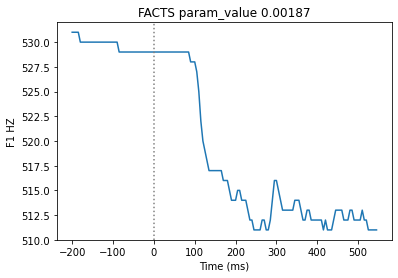

In [44]:
# Print an example trial 
examples = []
# mu1 = 0.005
param_values = [0.00187] #np.linspace(.0001, .0028, num=20)
plot = True

for ii in param_values:
    print(f"param_value {ii}")
    example = simulator(torch.tensor([ii]))
    examples.append(example)
    
    if plot == True:
        plt.figure()
        plt.title(f'FACTS param_value {ii}')
        example_x = (np.arange(len(example))*5)-200
        plt.plot(example_x,example)
        plt.axvline(x = 0, color = 'grey', ls=':')
        plt.xlabel('Time (ms)')
        plt.ylabel('F1 HZ')
        plt.show()


### Load Kyunghee's data and compare to FACTS

(1, 194)
(1797, 194)
(1, 150)
(1797, 150)


Text(0, 0.5, 'F1 HZ')

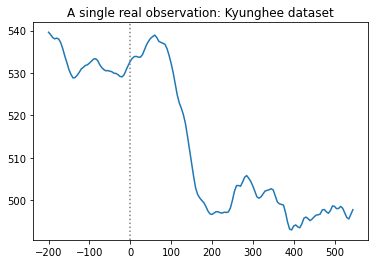

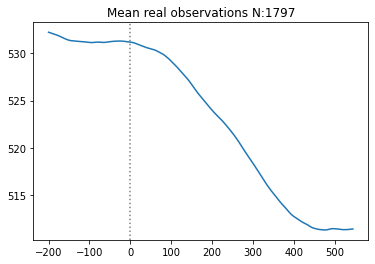

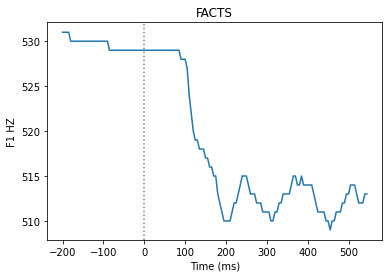

In [24]:
# Import real observed data
import scipy.io
example = examples[0]

trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_time_cleaned.mat')['time_matrix'].T
trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T # 1797 x 194 == trials by time

print(trial_cells_times.shape)
print(trial_cells_mat.shape)
trial_cells_times = trial_cells_times[:,0:150]
trial_cells_mat = trial_cells_mat[:,0:150]
print(trial_cells_times.shape)
print(trial_cells_mat.shape)

# # Alter the trial_cells so that they center to where FACTS centers
trial_cells_mat = trial_cells_mat + 531

# Plot and compare observed data to FACTS data
plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[729,:])
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title('A single real observation: Kyunghee dataset')
# plt.ylim([510,535])

plt.figure()
plt.plot(trial_cells_times[0,:]*1000, np.mean(trial_cells_mat, 0))
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title(f'Mean real observations N:{(trial_cells_mat.shape[0])}')
# plt.ylim([510,535])

# # Now realign so that 
plt.figure()
plt.title('FACTS')
example_x = (np.arange(len(example))*5)-200
plt.plot(example_x,example)
plt.axvline(x = 0, color = 'grey', ls=':')
plt.xlabel('Time (ms)')
plt.ylabel('F1 HZ')
# plt.ylim([510,535])

In [ ]:
print(np.min(trial_cells_mat[729,:]))
print(np.min(np.mean(trial_cells_mat, 0)))
# print(np.min(example))

In [50]:
from sbi.inference import infer
from sbi import utils as utils
import pickle
# import facts_for_SBI

load_instead = False

# High - 0.04
# Low - 0.0001
# import your simulator, define your prior over the parameters
prior_mean = 0.002
prior_min= [0.0001]
prior_mmax = [0.04] 
num_sim = 10000

# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
if load_instead == False:
    prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
    parameter_posterior = infer(simulator, prior, method='SNPE', num_simulations=num_sim, num_workers=6)
    with open(f'./sbi_resources/ModelC_auditory_noise_posterior_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([parameter_posterior], f)
    
else:
    file = open(f'./sbi_resources/ModelC_auditory_noise_posterior_{num_sim}.pkl', 'rb')
    object_file = pickle.load(file)
    pdb.set_trace()
    file.close()

Artic SFC Law Model Type:  lwpr
[10.90672863 36.06190914 53.07804592]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False
Artic SFC Law Model Type:  lwpr
[0.06547765 0.21649472 0.3186497 ]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.666692

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/alvincepongos/opt/anaconda3/envs/facts_sbi_env/lib/python3.6/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 39 epochs.


## Sample the posterior for a single point from Kyunghee's observations

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 0, 'Auditory noise scale')

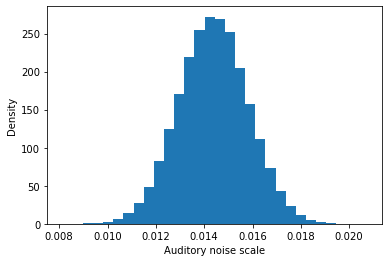

In [86]:
mean_trials = np.mean(trial_cells_mat, 0)
single_trial = trial_cells_mat[729]

samples = parameter_posterior.sample((100000,), x=single_trial)
log_probability = parameter_posterior.log_prob(samples, x=single_trial)
# out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')
test = samples.numpy()
# print(test[0])
n, bins, patches = plt.hist(test, density=True, bins=30)
plt.ylabel('Density')
plt.xlabel('Auditory noise scale')

## Sample the posterior for a single data point from the FACTS model itself

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

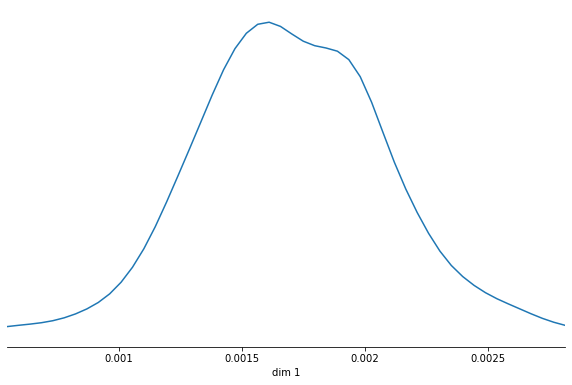

In [52]:
samples = parameter_posterior.sample((1000,), x=example)
log_probability = parameter_posterior.log_prob(samples, x=example)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

## Now plot for the mean of all trials

In [54]:
samples = parameter_posterior.sample((100,), x=mean_trials)
log_probability = parameter_posterior.log_prob(samples, x=mean_trials)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (100, 1)) to be within the support (Interval(lower_bound=tensor([1.0000e-04]), upper_bound=tensor([0.0400]))) of the distribution Uniform(low: tensor([1.0000e-04]), high: tensor([0.0400])), but found invalid values:
tensor([[ 0.0047],
        [ 0.0112],
        [ 0.0169],
        [ 0.0219],
        [-0.0013],
        [ 0.0193],
        [ 0.0142],
        [ 0.0122],
        [ 0.0167],
        [ 0.0147],
        [ 0.0004],
        [ 0.0003],
        [ 0.0209],
        [ 0.0112],
        [-0.0016],
        [ 0.0184],
        [ 0.0153],
        [ 0.0015],
        [ 0.0223],
        [ 0.0050],
        [ 0.0123],
        [ 0.0261],
        [ 0.0188],
        [ 0.0162],
        [ 0.0089],
        [ 0.0072],
        [ 0.0066],
        [ 0.0140],
        [ 0.0135],
        [ 0.0159],
        [ 0.0153],
        [ 0.0179],
        [ 0.0146],
        [ 0.0166],
        [ 0.0031],
        [ 0.0201],
        [ 0.0239],
        [ 0.0204],
        [ 0.0181],
        [ 0.0294],
        [ 0.0204],
        [ 0.0116],
        [ 0.0174],
        [ 0.0160],
        [ 0.0093],
        [ 0.0213],
        [ 0.0121],
        [-0.0004],
        [ 0.0153],
        [ 0.0195],
        [ 0.0047],
        [ 0.0250],
        [ 0.0105],
        [ 0.0086],
        [ 0.0006],
        [ 0.0154],
        [ 0.0146],
        [ 0.0181],
        [ 0.0198],
        [ 0.0049],
        [ 0.0167],
        [ 0.0268],
        [ 0.0091],
        [ 0.0131],
        [ 0.0083],
        [ 0.0181],
        [ 0.0183],
        [ 0.0210],
        [ 0.0047],
        [ 0.0092],
        [ 0.0293],
        [ 0.0183],
        [ 0.0074],
        [ 0.0140],
        [ 0.0169],
        [ 0.0107],
        [ 0.0069],
        [ 0.0151],
        [ 0.0251],
        [ 0.0094],
        [ 0.0148],
        [ 0.0161],
        [ 0.0044],
        [ 0.0125],
        [ 0.0120],
        [ 0.0142],
        [ 0.0131],
        [ 0.0218],
        [ 0.0182],
        [ 0.0172],
        [ 0.0079],
        [ 0.0163],
        [ 0.0177],
        [ 0.0083],
        [ 0.0156],
        [ 0.0126],
        [ 0.0094],
        [ 0.0106],
        [ 0.0100],
        [ 0.0183]])

BoxUniform(Uniform(low: tensor([1.0000e-04]), high: tensor([0.0400])), 1)


Text(0.5, 1.0, '10000 samples drawn from Box Uniform prior\n low: 1.0000e-04; high: 0.0400')

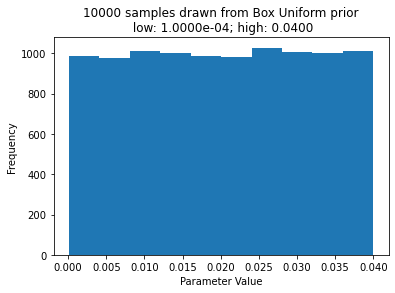

In [81]:
prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )

samplesk = []
n_samples = 10000
for kk in range(n_samples):
    samplesk.append(prior.sample())
    
print(prior)
plt.hist(samplesk)
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title(f'{n_samples} samples drawn from Box Uniform prior\n low: 1.0000e-04; high: 0.0400')

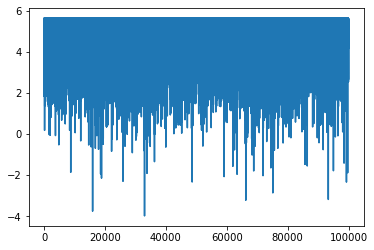

In [83]:
plt.plot(log_probability)

In [90]:
print(np.argmax(n))
print(bins[np.argmax(n)])

14
0.014016919


In [93]:
print(torch.std(samples))

tensor([[0.0151],
        [0.0125],
        [0.0137],
        ...,
        [0.0148],
        [0.0148],
        [0.0127]])
tensor(0.0014)


In [94]:
torch.cuda.is_available()

False